In [1]:
import numpy as np
import pandas as pd

from scipy.spatial import Voronoi
from skimage.draw import line_aa, polygon

from CellSeg.io import write_tiff

import matplotlib.pyplot as plt

In [2]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

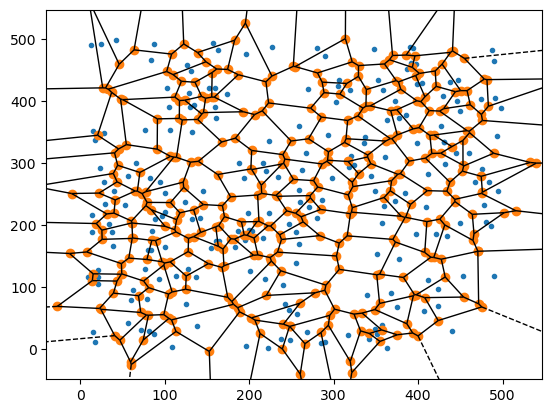

In [36]:
from scipy.spatial import voronoi_plot_2d

size_image = 500
points = np.random.uniform(0, size_image, (200, 2))
# Compute Voronoi
v = Voronoi(points)
voronoi_plot_2d(v)
plt.show()

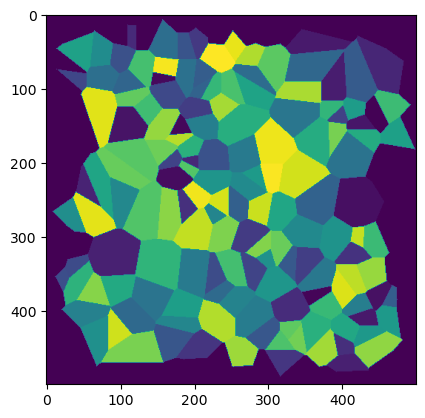

In [37]:
regions, vertices = voronoi_finite_polygons_2d(v)

# create empty image
img = np.zeros((150, size_image, size_image), 'uint8')

f = 1
for region in regions:
    poly = vertices[region]
    rr, cc = polygon(poly.flatten()[0::2].astype(int), poly.flatten()[1::2].astype(int))

    if (rr>=size_image).any() or (cc>=size_image).any():
        continue
    else:
        if (rr==0).any() or (cc==0).any():
            continue
        else:
            img[20:130, rr,cc] = f
            f+=1
    
plt.imshow(np.max(img, axis=0))

In [39]:
f

151

In [40]:
write_tiff(img, 
           "artificial_tissue_150cells")